In [272]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error

#import DL libs
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

plt.style.use('fivethirtyeight')


plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 12

%matplotlib inline


In [273]:
# util function

# util functions

def plot_distributions(X):
    """
    plots distribution of numerical data from dataframe
    """
    X = pd.melt(X)
    g = sns.FacetGrid(X, col="variable",  col_wrap=3, sharex=False, sharey=False)
    g = g.map(sns.distplot, "value")
    
def plot_missing_values(X):
    """
    plots missing values per column of  dataframe in a bar chart 
    """
    missing = X.isnull().sum()
    missing = missing[missing>0]
    missing.sort_values(inplace=True)
    missing.plot.bar()
    
def spearman(frame, features=[], target='y'):
    """
    plots spearman correlation of each features with target
    """
    spr = pd.DataFrame()
    print(features)
    spr['feature'] = features
    spr['spearman'] = [frame[f].corr(frame[target], 'spearman') for f in features]
    spr = spr.sort_values('spearman')
    plt.figure(figsize=(6, 0.25*len(features)))
    sns.barplot(data=spr, y='feature', x='spearman', orient='h')
    
    
def plot_corr_heatmap(X, title="Corr Heatmap"):
    X_corr = X.corr()
    plt.figure(figsize=(16,7))
    # Add title
    plt.title(title)
    mask = np.zeros_like(X_corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(mask=mask, data=X_corr, annot=True, cmap=cmap)
    
def pairplot_with_target(X, features, target):
    def pairplot(x, y, **kwargs):
        ax = plt.gca()
        ts = pd.DataFrame({'time': x, 'val': y})
        ts = ts.groupby('time').mean()
        ts.plot(ax=ax)
        plt.xticks(rotation=90)

    f = pd.melt(X, id_vars=[target], value_vars=features)
    g = sns.FacetGrid(f, col="variable",  col_wrap=3, sharex=False, sharey=False, size=5)
    g = g.map(pairplot, "value", target)

## PART 1

### 1)

In [274]:
#read datasets
btc_price = pd.read_csv('../data/BTCPrice.csv', index_col=['Date'])
btc_price.columns = ['PRICE']

btc_trd_vol = pd.read_csv('../data/BTCTradeVolume.csv', index_col=['Date'])
btc_trd_vol.columns = [ 'TRD_VOLUME']

btc_miner_fees =  pd.read_csv('../data/BTCtransaction-fees.csv', index_col=['Date'])
btc_miner_fees.columns = ['MINERS_FEE']


btc_transaction_vol = pd.read_csv('../data/BTCTransactionVolume.csv', index_col=['Date'])
btc_transaction_vol.columns = ['TRAN_VOL']

btc_price_vol = pd.read_csv('../data/BTCprice-volatility.csv', index_col=['Date'])
btc_price_vol.columns = ['PRICE_VOL']

btc_miner_revenue =  pd.read_csv('../data/BTCminer-revenue.csv', index_col=['Date'])
btc_miner_revenue.columns = ['MINERS_REVENUE']

btc_difficulty = pd.read_csv('../data/BTCDifficulty.csv', index_col=['Date'])
btc_difficulty.columns = ['DIFFICULTY']

btc_transaction_per_block = pd.read_csv('../data/BTCTransactionPerBlock.csv', index_col=['Date'])
btc_transaction_per_block.columns = ['TRAN_BLOCK']

btc_hash_rate = pd.read_csv('../data/BTChash-rate.csv', index_col=['Date'])
btc_hash_rate.columns = ['HASH_RATE'] 

bch_price =  pd.read_csv('../data/BCHprice.csv', index_col=['Date'])
bch_price.columns = ['BCH_PRICE']

btc_money_supply =  pd.read_csv('../data/BTCmoney-supply.csv', index_col=['Date'])
btc_money_supply.columns = ['MONEY_SUPPLY']



btc_data = pd.concat([btc_price, btc_trd_vol, btc_miner_fees, btc_transaction_vol, btc_price_vol,
                     btc_miner_revenue, btc_difficulty, btc_transaction_per_block, btc_hash_rate,
                     btc_money_supply, bch_price], axis=1, sort=True)
btc_data.index= pd.to_datetime(btc_data.index, format='%Y-%m-%d')
btc_data = btc_data.loc[(btc_data.index >= '2010-01-01') & (btc_data.index <= '2019-06-30')]

In [275]:
btc_data.head(10)


,PRICE,TRD_VOLUME,MINERS_FEE,TRAN_VOL,PRICE_VOL,MINERS_REVENUE,DIFFICULTY,TRAN_BLOCK,HASH_RATE,MONEY_SUPPLY,BCH_PRICE
2010-01-01,0.0,0.0,0.0,0.0,NaN,6900.0,1.0,1.0,0.000008,1624700.0,0.0
2010-01-02,0.0,0.0,0.0,100.0,NaN,6600.0,1.0,1.0,0.000008,1631300.0,0.0
2010-01-03,0.0,0.0,0.0,0.0,NaN,6300.0,1.0,1.0,0.000007,1637600.0,0.0
2010-01-04,0.0,0.0,0.0,20778.0,NaN,9300.0,1.0,1.0,0.000007,1646900.0,0.0
2010-01-05,0.0,0.0,0.0,0.0,NaN,9050.0,1.0,1.0,0.000008,1655950.0,0.0
2010-01-06,0.0,0.0,0.0,0.0,NaN,9900.0,1.0,1.0,0.000008,1665850.0,0.0
2010-01-07,0.0,0.0,0.0,0.0,NaN,8150.0,1.0,1.0,0.000008,1674000.0,0.0
2010-01-08,0.0,0.0,0.0,0.0,NaN,7700.0,1.0,1.0,0.000008,1681700.0,0.0
2010-01-09,0.0,0.0,0.0,0.0,NaN,7650.0,1.0,1.0,0.000008,1689350.0,0.0
2010-01-10,0.0,0.0,0.0,0.0,NaN,7550.0,1.0,1.0,0.000008,1696900.0,0.0


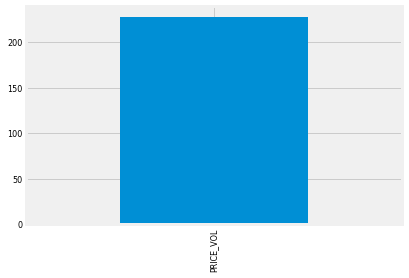

In [276]:
plot_missing_values(btc_data)
#just one column has nan values

Only PRICE_VOL colum column has missing values.

0 price does not make sense in the beginning of 2010. Its probably due to the lack of trading on exchanges at that time. It would be best to drop rows with 0 price or 0 trade volume. Since prices with 0 trading volume are also not reliable. Removing 0 price value also takes care of the missing value in the price vol column.


In [277]:
btc_data.to_csv('btc_data.csv')
btc_data = btc_data.drop(btc_data[btc_data['PRICE']==0].index)

In [278]:
btc_data.describe()

,PRICE,TRD_VOLUME,MINERS_FEE,TRAN_VOL,PRICE_VOL,MINERS_REVENUE,DIFFICULTY,TRAN_BLOCK,HASH_RATE,MONEY_SUPPLY,BCH_PRICE
count,3240.000000,3.240000e+03,3240.000000,3.240000e+03,3240.000000,3240.000000,3.240000e+03,3240.000000,3.240000e+03,3.240000e+03,3240.000000
mean,1784.235752,1.291471e+08,61.613730,2.034392e+05,76.235959,4399.985644,1.041392e+12,883.314062,7.608236e+06,1.287301e+07,436.786290
std,3097.652417,3.324501e+08,111.997930,2.528356e+05,50.449536,2519.248731,2.101884e+12,765.905471,1.525644e+07,3.899653e+06,538.467441
min,0.060900,5.131510e+01,0.000000,6.221000e+03,0.000000,1242.089114,5.120000e+02,1.000000,3.970459e-03,3.739600e+06,0.060000
25%,13.712525,6.742530e+05,12.662478,1.073318e+05,39.107889,2166.924622,3.054628e+06,224.000000,2.176505e+01,1.031562e+07,13.440000
50%,385.080000,7.818132e+06,24.843805,1.719355e+05,64.459420,3830.998224,4.127287e+10,632.500000,3.110143e+05,1.375114e+07,287.605000
75%,1230.232719,8.482045e+07,52.676742,2.522833e+05,99.656925,5903.135531,4.996359e+11,1536.395369,3.697014e+06,1.626728e+07,606.700000
max,19498.683333,5.352016e+09,1495.748916,5.825066e+06,272.447767,15371.520742,7.934713e+12,2762.540984,6.219192e+07,1.778861e+07,3810.470000


### 2)

Text(0.5, 0, 'date')

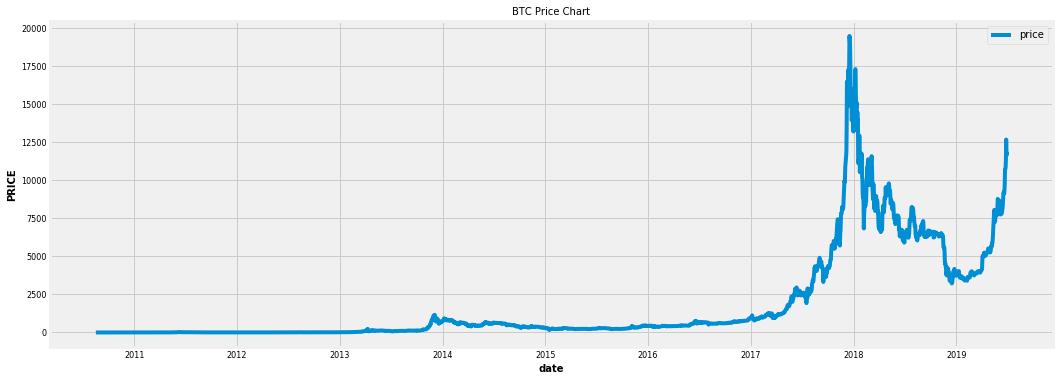

In [279]:
plt.figure(figsize=(16,6))
plt.title('BTC Price Chart')
sns.lineplot(btc_data.index, btc_data['PRICE'], label='price')
plt.xlabel('date')

### 2 & 3)

In [282]:
# lets split our data set before we do analysis on data set to make testing phase completely independent

target = 'PRICE'
base_features = btc_data.columns

train_mask = (btc_data.index >= '2010-01-01') & (btc_data.index <= '2018-06-30')
valid_mask = (btc_data.index >= '2018-07-01') & (btc_data.index <= '2018-12-31')
test_mask = (btc_data.index >= '2019-01-01') & (btc_data.index <= '2019-06-30')

X_train =  btc_data.loc[train_mask][base_features]
y_train =  pd.DataFrame(btc_data.loc[train_mask][target])

X_valid =  btc_data.loc[valid_mask][base_features]
y_valid = pd.DataFrame(btc_data.loc[valid_mask][target])

X_test =  btc_data.loc[test_mask][base_features]
y_test =  pd.DataFrame(btc_data.loc[test_mask][target])

missing = X_train.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)

In [283]:
#using constant imputer for price volatility and standard scaler for normalization
constant_imputer = SimpleImputer(strategy='constant')

#normalizer
normalizer = StandardScaler()

def preprocessing_pipeline(X, train=False):
    ind = X.index
    if  train:
        X = pd.DataFrame(constant_imputer.fit_transform(X), columns=base_features)
        X = pd.DataFrame(normalizer.fit_transform(X), columns=base_features)
    else:
        X = pd.DataFrame(constant_imputer.transform(X), columns=base_features)
        
        X = pd.DataFrame(normalizer.transform(X), columns=base_features)
    X.index = ind
    return X
        
    
X_train = preprocessing_pipeline(X_train, train=True)
X_valid = preprocessing_pipeline(X_valid, train=False)
X_test = preprocessing_pipeline(X_test, train=False)

print(X_train.head())
X_train.describe()

               PRICE  TRD_VOLUME  MINERS_FEE  TRAN_VOL  PRICE_VOL  \
2010-08-17 -0.448879   -0.313495   -0.534373 -0.614176   3.109663   
2010-08-18 -0.448880   -0.313497   -0.540073 -0.661082   1.865370   
2010-08-19 -0.448882   -0.313496   -0.526801 -0.743868   1.759482   
2010-08-20 -0.448882   -0.313496   -0.540073 -0.716115   1.671825   
2010-08-21 -0.448882   -0.313496   -0.540073 -0.729967   1.671825   

            MINERS_REVENUE  DIFFICULTY  TRAN_BLOCK  HASH_RATE  MONEY_SUPPLY  \
2010-08-17        1.053534   -0.401345   -1.088262  -0.400393     -2.275506   
2010-08-18        0.692685   -0.401345   -1.088262  -0.400393     -2.273790   
2010-08-19        0.773439   -0.401345   -1.088262  -0.400393     -2.272020   
2010-08-20        0.812879   -0.401345   -1.088262  -0.400393     -2.270224   
2010-08-21        1.974750   -0.401345   -1.088262  -0.400393     -2.267656   

            BCH_PRICE  
2010-08-17  -0.788172  
2010-08-18  -0.788172  
2010-08-19  -0.788172  
2010-08-20  -0

,PRICE,TRD_VOLUME,MINERS_FEE,TRAN_VOL,PRICE_VOL,MINERS_REVENUE,DIFFICULTY,TRAN_BLOCK,HASH_RATE,MONEY_SUPPLY,BCH_PRICE
count,2875.000000,2.875000e+03,2875.000000,2.875000e+03,2.875000e+03,2.875000e+03,2875.000000,2.875000e+03,2875.000000,2.875000e+03,2.875000e+03
mean,0.000000,3.954325e-17,0.000000,9.885812e-18,-3.954325e-17,3.163460e-16,0.000000,7.908650e-17,0.000000,1.581730e-16,-1.186297e-16
std,1.000174,1.000174e+00,1.000174,1.000174e+00,1.000174e+00,1.000174e+00,1.000174,1.000174e+00,1.000174,1.000174e+00,1.000174e+00
min,-0.448885,-3.134968e-01,-0.540073,-7.721767e-01,-1.490480e+00,-1.393840e+00,-0.401345,-1.088262e+00,-0.400393,-2.275506e+00,-7.881899e-01
25%,-0.444753,-3.121002e-01,-0.438186,-3.824860e-01,-7.565535e-01,-7.451214e-01,-0.401343,-8.086690e-01,-0.400391,-7.123824e-01,-7.677048e-01
50%,-0.351452,-3.010534e-01,-0.328292,-1.133388e-01,-2.366451e-01,-2.938770e-01,-0.382098,-4.339270e-01,-0.380459,2.031693e-01,-3.008051e-01
75%,-0.216909,-2.297856e-01,-0.091774,1.808648e-01,4.703252e-01,7.942262e-01,-0.168808,8.609313e-01,-0.177799,9.212800e-01,3.105858e-01
max,6.386659,1.545348e+01,12.185104,2.108921e+01,3.687868e+00,4.267051e+00,5.235757,2.895751e+00,5.560695,1.285660e+00,5.943735e+00


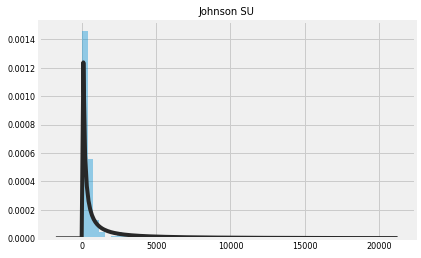

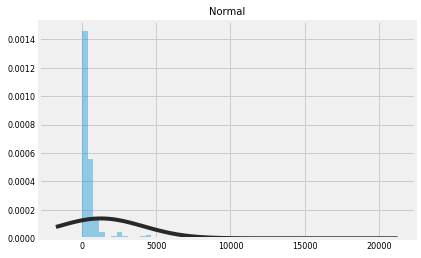

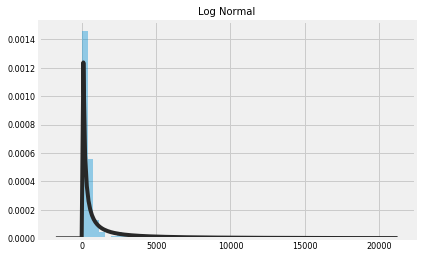

In [284]:
import scipy.stats as st
plt.figure(1); plt.title('Johnson SU')
sns.distplot(y_train, kde=False, fit=st.johnsonsu)
plt.figure(2); plt.title('Normal')
sns.distplot(y_train, kde=False, fit=st.norm)
plt.figure(3); plt.title('Log Normal')
sns.distplot(y_train, kde=False, fit=st.lognorm)

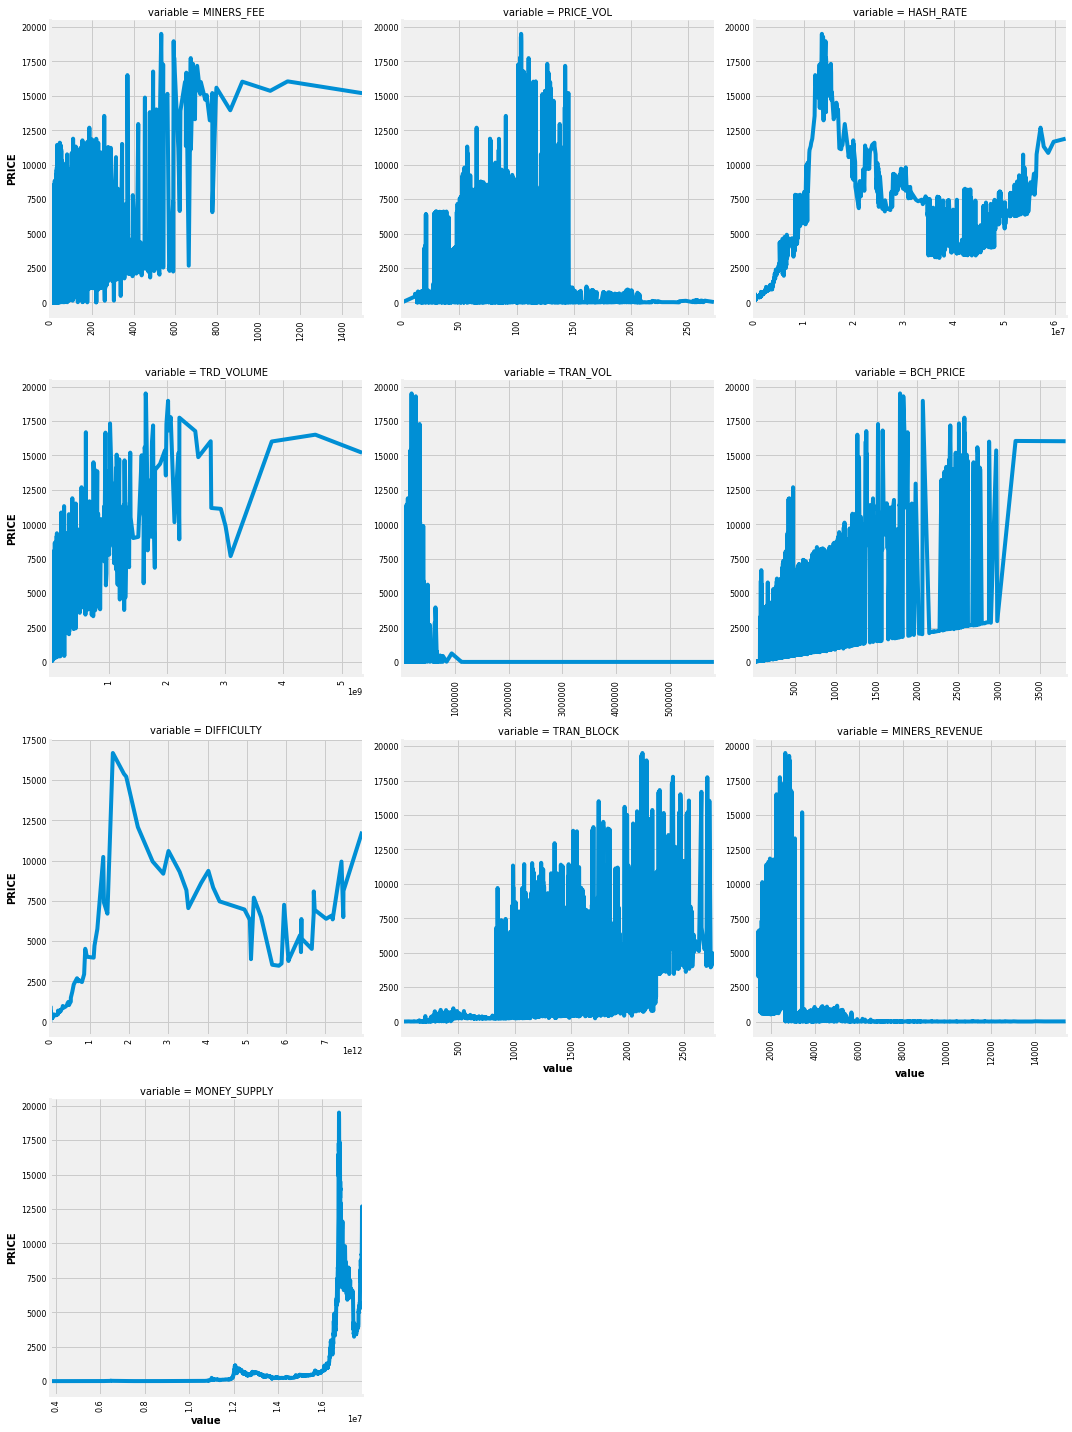

In [306]:
# print(list(base_features))
pairplot_with_target(btc_data, list(set(base_features) - set(['PRICE'])), 'PRICE')

We can see some linear relationship of target variable with features

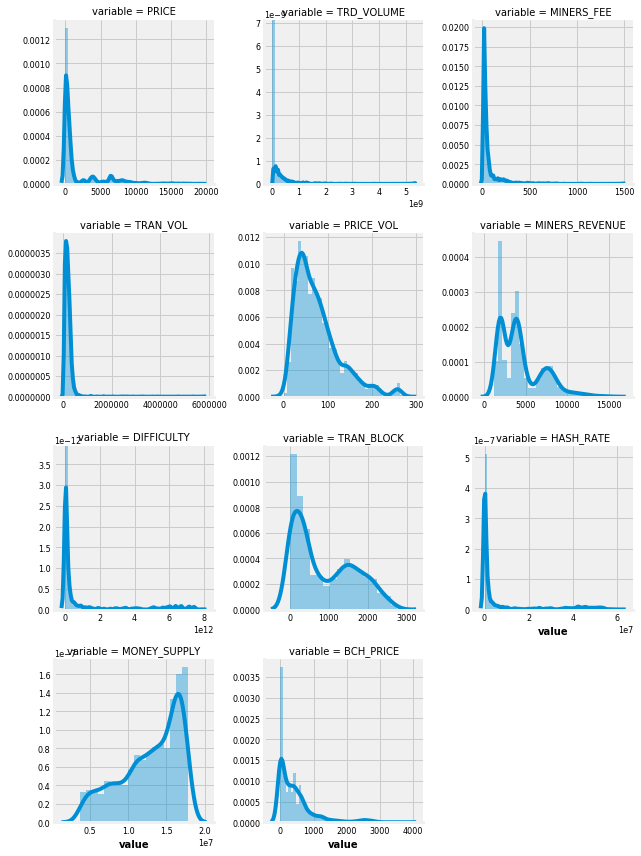

In [286]:
plot_distributions(btc_data)

Prices, price_vol, hash_rate, TRAN_VOL appear to be following lognormal distribution. We can make log transformation to make distributions bit symmetrical

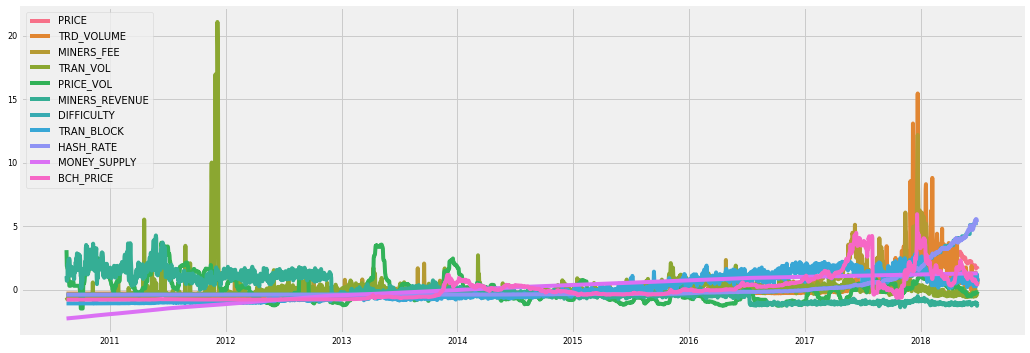

In [287]:
#plot all columns in same chart 
plt.figure(figsize=(16,6))

sns.lineplot(data=X_train, dashes=False)


### 4)

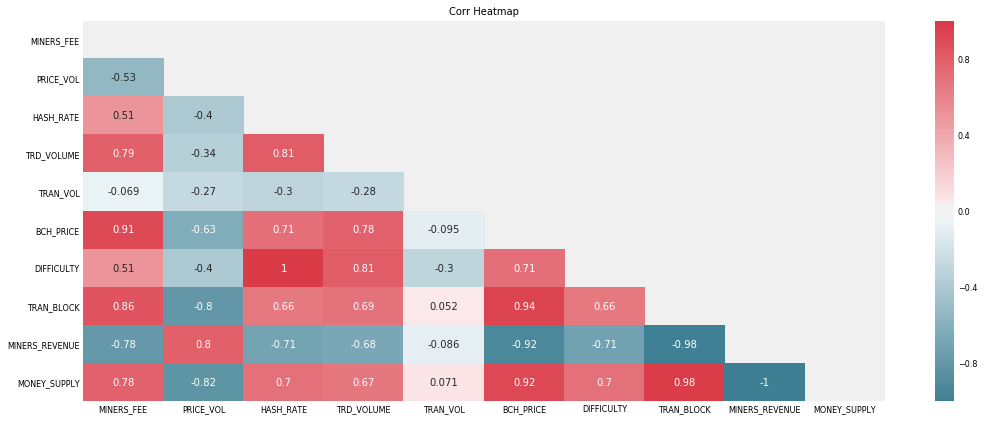

In [288]:
plot_corr_heatmap(train_corr)

In [289]:
## pair plot of all variable with each other and target
# sns.pairplot(btc_data, size = 3.5)

highly correlated

1)Money supply and transections per block 

2)BCH price and transections per block 

3) Market cap and difficulty of mining bitcoin

4) hashrate and difficulty are almost perfectly correlated(we should drop one of thesse)

5) miners fee and bch price

6) transections per block and bch price

7) market cap and hash rate

Negatively corr

1) Miners revenue and transections per block 

2) Miners revenue and money supply(number of bitcoins)


We should drop difficulty as it is highly correlated with hashrate and trd volume.


In [394]:
X_train = X_train.drop(['DIFFICULTY'], axis=1)
X_test = X_test.drop(['DIFFICULTY'], axis=1)
X_valid = X_valid.drop(['DIFFICULTY'], axis=1)

### Observations

1) We have missing values for price volatility

2) Std dev of most of the columns is pretty high since 2010

3) We should reduce highly correlated features (this can be done using greedy algorithms or relying on L1 regularization of NNs)

4) Standardised features are not stationary which is evident from high shocks(non constant volatility) in the time series plot.



## Part 2

Basic Pre processing and split done in sub parts 2,3 of Part 1.

Now, lets do feture engineering to derive more predictors from past 28 days.
First lets concat features from last 28 days and also create 


In [291]:
#### data processing Utils
def create_lagged_features(X, lag=3, dropna=False):
    """
    This function creates the lagged feature dataframe specifically useful for time series modelling
    """
    lagged_dfs = [ X.shift(i).add_suffix('_' + str(i)) for i in range(lag)]
    if dropna:
        lagged_dfs = lagged_dfs.dropna()
    return pd.concat(lagged_dfs, axis=1)

def create_leading_targets(X, lead=3, dropna=False):
    """
    This function creates leading targets specifically useful for predicting over multiple periods
    """
    leading_df = [ X.shift(-i).add_suffix('_' + str(i)) for i in range(1, lead+1)]
    if dropna:
        leading_df = leading_df.dropna()
    return pd.concat(leading_df, axis=1)

In [395]:
X_train_lagged = create_lagged_features(X_train, lag=28)[28:-7]
y_train_leading = create_leading_targets(pd.DataFrame(y_train), lead=7)[28:-7]

In [397]:
X_valid_lagged = create_lagged_features(X_valid, lag=28)[28:-7]
y_valid_leading = create_leading_targets(pd.DataFrame(y_valid), lead=7)[28:-7]

X_test_lagged = create_lagged_features(X_test, lag=28)[28:-7]
y_test_leading = create_leading_targets(pd.DataFrame(y_test), lead=7)[28:-7]

we will start trading after 28 days and also stop trading 7 days befor to avoid handle NaN cases 

Lets see verify whether input features are based on 28 days look back period and targets on next periods

In [294]:
X_train_lagged.head()

,PRICE_0,TRD_VOLUME_0,MINERS_FEE_0,TRAN_VOL_0,PRICE_VOL_0,MINERS_REVENUE_0,TRAN_BLOCK_0,HASH_RATE_0,MONEY_SUPPLY_0,BCH_PRICE_0,...,PRICE_27,TRD_VOLUME_27,MINERS_FEE_27,TRAN_VOL_27,PRICE_VOL_27,MINERS_REVENUE_27,TRAN_BLOCK_27,HASH_RATE_27,MONEY_SUPPLY_27,BCH_PRICE_27
2010-09-14,-0.448883,-0.313493,-0.540073,-0.713823,0.299859,1.534040,-1.088262,-0.400393,-2.211764,-0.78819,...,-0.448880,-0.313497,-0.540073,-0.661082,1.865370,0.692685,-1.088262,-0.400393,-2.273790,-0.788172
2010-09-15,-0.448845,-0.313494,-0.539991,-0.692938,0.299859,2.175077,-1.086798,-0.400393,-2.209063,-0.78819,...,-0.448882,-0.313496,-0.526801,-0.743868,1.759482,0.773439,-1.088262,-0.400393,-2.272020,-0.788172
2010-09-16,-0.448884,-0.313497,-0.540073,-0.718373,0.299859,1.493976,-1.085334,-0.400393,-2.206815,-0.78819,...,-0.448882,-0.313496,-0.540073,-0.716115,1.671825,0.812879,-1.088262,-0.400393,-2.270224,-0.788172
2010-09-17,-0.448885,-0.313496,-0.540073,-0.685022,0.299859,2.495589,-1.083870,-0.400393,-2.203901,-0.78819,...,-0.448882,-0.313496,-0.540073,-0.729967,1.671825,1.974750,-1.088262,-0.400393,-2.267656,-0.788172
2010-09-18,-0.448885,-0.313496,-0.540073,-0.553181,0.299859,2.275234,-1.085334,-0.400393,-2.201133,-0.78819,...,-0.448883,-0.313493,-0.540073,-0.682948,1.005149,1.574105,-1.088262,-0.400393,-2.265354,-0.788172


In [321]:
y_train_leading.tail()

,PRICE_1,PRICE_2,PRICE_3,PRICE_4,PRICE_5,PRICE_6,PRICE_7
2018-06-19,6737.000000,6714.718333,6733.901667,6332.573333,6141.605833,6037.008333,6211.447500
2018-06-20,6714.718333,6733.901667,6332.573333,6141.605833,6037.008333,6211.447500,6218.595000
2018-06-21,6733.901667,6332.573333,6141.605833,6037.008333,6211.447500,6218.595000,6105.295000
2018-06-22,6332.573333,6141.605833,6037.008333,6211.447500,6218.595000,6105.295000,6107.896154
2018-06-23,6141.605833,6037.008333,6211.447500,6218.595000,6105.295000,6107.896154,5908.702500


## Part 3

Now that are data sets are ready lets start training.

But before that lets create score function

In [296]:
def get_model_score(model, X, y_true):
    y_pred = model.predict(X)
    return mean_absolute_error(y_true, y_pred)

### 1) Average and Last Value model

In [398]:
def get_avg_model_preds(y_val):
    y_preds = []
    for index, val in y_val.iterrows():
        ind_in_full_data = btc_data.index.get_loc(index)
        pred = btc_data.iloc[ind_in_full_data-28:ind_in_full_data]['PRICE'].mean()
        y_preds.append(np.ones(7)*pred)
    return y_preds

def get_last_val_preds(y_val):
    y_preds = []
    for index, val in y_val.iterrows():
        ind_in_full_data = btc_data.index.get_loc(index)
        pred = btc_data.iloc[ind_in_full_data-1]['PRICE']
        y_preds.append(np.ones(7)*pred)
    return y_preds

last_val_preds = get_last_val_preds(y_valid_leading)
avg_model_preds = get_avg_model_preds(y_valid_leading)

print("avg benchmark score: ", mean_absolute_error(y_valid_leading, last_val_preds))
print("last val benchmark score: ", mean_absolute_error(y_valid_leading, avg_model_preds))

avg benchmark score:  309.17370001833166
last val benchmark score:  554.3354632715694


### 2)  simple neural network 

In [399]:
simple_nn = Sequential()
simple_nn.add(Dense(50, input_dim=280, activation='relu'))
simple_nn.add(Dense(50, activation='relu'))
simple_nn.add(Dense(7, activation='linear'))
simple_nn.compile(loss='mae', optimizer='adam')
simple_nn.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 50)                14050     
_________________________________________________________________
dense_10 (Dense)             (None, 50)                2550      
_________________________________________________________________
dense_11 (Dense)             (None, 7)                 357       
Total params: 16,957
Trainable params: 16,957
Non-trainable params: 0
_________________________________________________________________


In [414]:
h = simple_nn.fit(X_train_lagged, y_train_leading, epochs=100)

Epoch 1/100
2840/2840 [==============================] - 0s 68us/step - loss: 173.3490
Epoch 2/100
2840/2840 [==============================] - 0s 61us/step - loss: 169.2221
Epoch 3/100
2840/2840 [==============================] - 0s 62us/step - loss: 165.0381
Epoch 4/100
2840/2840 [==============================] - 0s 55us/step - loss: 162.1290
Epoch 5/100
2840/2840 [==============================] - 0s 55us/step - loss: 162.0067
Epoch 6/100
2840/2840 [==============================] - 0s 77us/step - loss: 156.2658
Epoch 7/100
2840/2840 [==============================] - 0s 99us/step - loss: 154.1475
Epoch 8/100
2840/2840 [==============================] - 0s 95us/step - loss: 152.3170
Epoch 9/100
2840/2840 [==============================] - 0s 87us/step - loss: 149.2611
Epoch 10/100
2840/2840 [==============================] - 0s 58us/step - loss: 146.8889
Epoch 11/100
2840/2840 [==============================] - 0s 57us/step - loss: 145.3019
Epoch 12/100
2840/2840 [=================

In [417]:
y_valid_pred = simple_nn.predict(X_valid_lagged)

In [419]:
print("simple nn validation score: ", get_model_score(simple_nn, X_valid_lagged, y_valid_leading))

simple nn validation score:  88.75159674348676


Really poor performance on validation set ! 